<a href="https://colab.research.google.com/github/marant482/MLclass/blob/main/Last%20assigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Przedstawione rozwiązanie jest ściśle oparte na sugestiach zawartych w treści zadania.



1.   Pierwszym krokiem jest przekształcenie dwuwymiarowego obrazu w sekwencję wektorów cech, która może być przetwarzana przez mechanizm atencji. W tym celu zastosowałem warstwę konwolucyjną. Zgodnie z sugestią, warstwa ta ma jądro o rozmiarze 20x20, stride=4 i padding=0. Taka konfiguracja dzieli wejściowy obraz (1, 64, 64) na siatkę 12x12 nachodzących na siebie fragmentów (receptive fields) i dla każdego z nich generuje wektor cech o wymiarze 32. W ten sposób obraz zostaje przekształcony w sekwencję 144 "tokenów" wizualnych, gdzie każdy token reprezentuje lokalny region obrazu.
2.   Positional Encoding - Aby dostarczyć modelowi informacji o przestrzennym układzie fragmentów obrazu, do każdego wektora cech dodawane jest sinusoidalne kodowanie pozycyjne. Zostało ono zaimplementowane identycznie jak na zajęciach.
3.   Self Attention - Każdy z 144 tokenów z informacją pozycyjną jest liniowo transformowany do trzech różnych bloków - Query Key i Value.
4. MLP - Po przetworzeniu przez warstwę atencji, otrzymujemy 144 "kontekstowe" wektory cech. Każdy z 144 wektorów jest niezależnie przepuszczany przez prostą, dwuwarstwową sieć MLP, która pełni rolę klasyfikatora. Na wyjściu klasyfikator generuje pojedynczy logit dla każdej pozycji, który reprezentuje "prawdopodobieństwo" znalezienia w tym miejscu nietypowego kształtu. Następnie logity są softmaxowane i finalna predykcja jest otrzymywana poprzez soft-argmax.

Trening:
Po różnych próbach zdecydowałem się na batch size= 250 i trening na 500 epochach. Jedna epocha ma 25000 obrazków,czyli 100 batchy.

Zastosowałem optymalizator Adam oraz stopniowo zmiejszający się learning rate- zacząłem od 0.002, a gdy predykcja nie zmiejszyła się po 20 epochach, learning rate zmniejszał się o połowę.
Poprawiło to znacząco wcześniejsze treningi, które szybko stabilizowały się na pewnym poziomie, robiąc za duże skoki, oraz przyspieszyło to początkową fazę treningu, bo mogłem zacząć od większego learning rate'u.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import math
import time
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

Używane urządzenie: cuda


In [84]:
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [85]:
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    """
    Generates images on-the-fly:
      * several random shapes of the same type
      * 1 additional shape of a different type
    Returns:
      * image (1×64×64 tensor, float32 normalized to [0,1])
      * label: float tensor [cx, cy] with center of the odd shape
    Arguments:
        num_samples             – total number of samples in the dataset
        same_shape_count_range – tuple (min, max), number of identical shapes
        shape_radius_range      – tuple (min_radius, max_radius) for shape size
    """
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        # draw identical shapes
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE - radius - 1)
            cy = random.randint(radius, IMAGE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        # draw the odd shape (with known center)
        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE - radius - 1)
        cy = random.randint(radius, IMAGE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_tensor, label_tensor

In [86]:
EMBED_DIM = 32
K_DIM = 16
V_DIM = 32
CLASSIFIER_HIDDEN = 64

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, k_dim, v_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.k_dim = k_dim
        self.v_dim = v_dim
        self.Q = nn.Linear(embed_dim, k_dim)
        self.K = nn.Linear(embed_dim, k_dim)
        self.V = nn.Linear(embed_dim, v_dim)
        self.attention_weights = None

    def forward(self, features): # Wymiar: (B, L, E)
        B, L, E = features.shape
        queries = self.Q(features)  # (B, L, K)
        keys = self.K(features)     # (B, L, K)
        values = self.V(features)   # (B, L, V)

        energies = torch.bmm(queries, keys.transpose(1, 2)) # (B, L, L)
        energies = energies / (self.k_dim ** 0.5)

        self.attention_weights = F.softmax(energies, dim=-1) # (B, L, L)
        # Mnożenie (B, L, L) @ (B, L, V)
        output = torch.bmm(self.attention_weights, values) # (B, L, V)
        return output

In [87]:
def sinusoid_positions(max_len, dim):
    pos = torch.arange(max_len, device=device).float().unsqueeze(1)
    i = torch.arange(dim, device=device).float().unsqueeze(0)
    angle = pos / (1000 ** (2 * (i // 2) / dim))
    S = torch.zeros(max_len, dim, device=device)
    S[:, 0::2] = torch.sin(angle[:, 0::2])
    S[:, 1::2] = torch.cos(angle[:, 1::2])
    return S

In [88]:
class OddShapesNet(nn.Module):
    def __init__(self, grid_size=12, embed_dim=EMBED_DIM, k_dim=K_DIM, v_dim=V_DIM, classifier_hidden=CLASSIFIER_HIDDEN):
        super().__init__()
        self.grid_size = grid_size
        self.num_patches = grid_size * grid_size # 144
        self.embed_dim = embed_dim

        # konwolucja
        self.embedding_cnn = nn.Conv2d(1, embed_dim, kernel_size=20, stride=4, padding=0)

        # positional encoding
        self.pos_encoding = sinusoid_positions(self.num_patches, embed_dim)

        # Atencja
        self.attention = SelfAttention(embed_dim, k_dim, v_dim)

        # MLP
        self.classifier = nn.Sequential(
            nn.Linear(v_dim, classifier_hidden),
            nn.ReLU(),
            nn.Linear(classifier_hidden, 1)
        )

        # Pre-obliczenie środków pól recepcyjnych dla soft-argmax
        centers = torch.zeros(self.num_patches, 2)
        stride, kernel_size = 4, 20
        offset = kernel_size / 2
        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                centers[idx, 0] = j * stride + offset # cx
                centers[idx, 1] = i * stride + offset # cy
        self.register_buffer('receptive_field_centers', centers) # (144, 2)

    def forward(self, x):
        # Wejście x: (B, 1, 64, 64)
        features = self.embedding_cnn(x) #(B, E, 12, 12)
        B, C, H, W = features.shape
        features = features.view(B, C, H * W).transpose(1, 2) # (B, 144, E)
        features = features + self.pos_encoding # (B, 144, E)
        attended_features = self.attention(features) # (B, 144, V)
        logits = self.classifier(attended_features) # (B, 144, 1)
        logits = logits.squeeze(-1) # (B, 144)
        probs = F.softmax(logits, dim=-1) # (B, 144)
        predicted_xy = torch.matmul(probs, self.receptive_field_centers) # (B, 2)
        return predicted_xy

In [89]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [90]:
EPOCH_SIZE = 25000
BATCH_SIZE = 250
NUM_EPOCHS = 500
LEARNING_RATE = 0.002

# Inicjalizacja modelu, kryterium i optymalizatora
model = OddShapesNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

# Online dataset - tworzymy nowy dla każdej epoki
train_dataset = OddXYDataset(num_samples=EPOCH_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True) #num workers pozwala na wczytywanie następnych danych w trakcie przetwarzania jednych


In [ ]:
# PĘTLA TRENINGOWA

In [91]:
print("Rozpoczynam trening...")
start_time = time.time()
loss_history = []

for epoch in range(NUM_EPOCHS):
  print(f"learning rate: {scheduler.get_last_lr()}")
  epoch_loss = 0.0
  model.train()
  for i, (images, labels) in enumerate(train_loader):
      images = images.to(device) # (B, 1, 64, 64)
      labels = labels.to(device) # (B, 2)

      optimizer.zero_grad()
      predictions = model(images) # (B, 2)
      loss = criterion(predictions, labels)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item() * images.size(0)

  avg_epoch_loss = epoch_loss / len(train_loader.dataset)
  rmse = math.sqrt(avg_epoch_loss)
  loss_history.append(rmse)

  print(f"Epoka {epoch+1}/{NUM_EPOCHS}, Średni Loss (MSE): {avg_epoch_loss:.4f}, RMSE: {rmse:.4f}")

  scheduler.step(avg_epoch_loss)

end_time = time.time()
print(f"\nTrening zakończony. Czas trwania: {end_time - start_time:.2f} sekund.")

Rozpoczynam trening...
learning rate: [0.002]
Epoka 1/500, Średni Loss (MSE): 183.1787, RMSE: 13.5344
learning rate: [0.002]
Epoka 2/500, Średni Loss (MSE): 178.7645, RMSE: 13.3703
learning rate: [0.002]
Epoka 3/500, Średni Loss (MSE): 161.9770, RMSE: 12.7270
learning rate: [0.002]
Epoka 4/500, Średni Loss (MSE): 152.8150, RMSE: 12.3618
learning rate: [0.002]
Epoka 5/500, Średni Loss (MSE): 137.8871, RMSE: 11.7425
learning rate: [0.002]
Epoka 6/500, Średni Loss (MSE): 128.1137, RMSE: 11.3187
learning rate: [0.002]
Epoka 7/500, Średni Loss (MSE): 122.9088, RMSE: 11.0864
learning rate: [0.002]
Epoka 8/500, Średni Loss (MSE): 116.1530, RMSE: 10.7774
learning rate: [0.002]
Epoka 9/500, Średni Loss (MSE): 115.1168, RMSE: 10.7293
learning rate: [0.002]
Epoka 10/500, Średni Loss (MSE): 109.8364, RMSE: 10.4803
learning rate: [0.002]
Epoka 11/500, Średni Loss (MSE): 106.7696, RMSE: 10.3329
learning rate: [0.002]
Epoka 12/500, Średni Loss (MSE): 104.6655, RMSE: 10.2306
learning rate: [0.002]
Epo

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^if w.is_alive():
       ^^^^^^^^

Epoka 256/500, Średni Loss (MSE): 50.5920, RMSE: 7.1128
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>

 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
^^   ^ ^   ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^ ^ 
   File "/usr/lib/py

Epoka 257/500, Średni Loss (MSE): 49.9208, RMSE: 7.0655
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    ^self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():^^
^ ^ ^ ^^^ ^^  ^^ ^^^^

Epoka 258/500, Średni Loss (MSE): 48.6644, RMSE: 6.9760
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^Exception ignored in: ^^^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

     self._shutdown_workers()       
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():
    ^ ^ ^^^^^^^^^^^^^^ ^ ^^^^^^^^

Epoka 259/500, Średni Loss (MSE): 49.3460, RMSE: 7.0247
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^^    ^if w.is_alive():^

   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
       ^^     ^ ^^ ^ ^^^^^^^^^^^^^^
^  F

Epoka 260/500, Średni Loss (MSE): 48.9218, RMSE: 6.9944
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()    if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
       ^ ^^  ^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'
 ^ ^  
   File "/usr/lib/p

Epoka 261/500, Średni Loss (MSE): 49.6397, RMSE: 7.0455
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^^    self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^^^^if w.is_alive():
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      assert self._parent_pid == os.getpid(), 'can only test a child process'
      ^ ^ ^ ^ ^ ^ ^ ^ ^  ^^^^^^
^  File "

Epoka 262/500, Średni Loss (MSE): 49.0336, RMSE: 7.0024
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
  ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^^if w.is_alive():^
^      ^ ^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
  ^ ^ ^^ ^ 
  File "/usr/lib/

Epoka 263/500, Średni Loss (MSE): 48.0435, RMSE: 6.9313
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers() ^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^^if w.is_alive():^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
               ^^ ^^^^^^^^^^^^^^^^^^^^^^^

Epoka 264/500, Średni Loss (MSE): 50.1121, RMSE: 7.0790
learning rate: [0.00025]


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220><function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
         ^^ ^ ^^ ^^ ^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
   ^  ^   ^   ^^^^^^^^^
^^^^  F

Epoka 265/500, Średni Loss (MSE): 49.8353, RMSE: 7.0594
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():

   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
      ^ ^^ ^ ^ ^^^ ^ ^ ^ ^ 
^  File "/us

Epoka 266/500, Średni Loss (MSE): 48.0554, RMSE: 6.9322
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoka 267/500, Średni Loss (MSE): 49.0613, RMSE: 7.0044
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():

   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process' 
          ^^^   ^  ^^^^ ^^^^^^^^
  File "

Epoka 268/500, Średni Loss (MSE): 49.9934, RMSE: 7.0706
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 if w.is_alive():
        ^^^   ^ ^ ^^^^^^^^^^^^
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'^^^
^^^^ 
   File "/usr/lib/pyth

Epoka 269/500, Średni Loss (MSE): 49.9737, RMSE: 7.0692
learning rate: [0.00025]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee0007d4220>
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^

Epoka 270/500, Średni Loss (MSE): 49.6174, RMSE: 7.0440
learning rate: [0.00025]
Epoka 271/500, Średni Loss (MSE): 49.0223, RMSE: 7.0016
learning rate: [0.00025]
Epoka 272/500, Średni Loss (MSE): 49.5118, RMSE: 7.0365
learning rate: [0.00025]
Epoka 273/500, Średni Loss (MSE): 48.2381, RMSE: 6.9454
learning rate: [0.00025]
Epoka 274/500, Średni Loss (MSE): 48.6244, RMSE: 6.9731
learning rate: [0.00025]
Epoka 275/500, Średni Loss (MSE): 48.5120, RMSE: 6.9651
learning rate: [0.00025]
Epoka 276/500, Średni Loss (MSE): 49.3833, RMSE: 7.0273
learning rate: [0.00025]
Epoka 277/500, Średni Loss (MSE): 49.6075, RMSE: 7.0433
learning rate: [0.00025]
Epoka 278/500, Średni Loss (MSE): 49.2622, RMSE: 7.0187
learning rate: [0.00025]
Epoka 279/500, Średni Loss (MSE): 50.6875, RMSE: 7.1195
learning rate: [0.00025]
Epoka 280/500, Średni Loss (MSE): 48.4133, RMSE: 6.9580
learning rate: [0.00025]
Epoka 281/500, Średni Loss (MSE): 49.1092, RMSE: 7.0078
learning rate: [0.00025]
Epoka 282/500, Średni Loss (

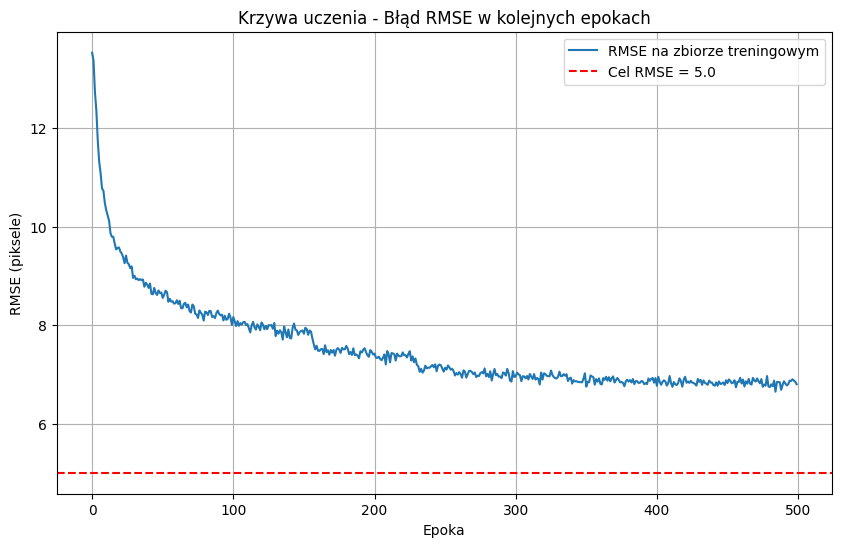

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='RMSE na zbiorze treningowym')
plt.axhline(y=5.0, color='r', linestyle='--', label='Cel RMSE = 5.0')
plt.title('Krzywa uczenia - Błąd RMSE w kolejnych epokach')
plt.xlabel('Epoka')
plt.ylabel('RMSE (piksele)')
plt.legend()
plt.grid(True)
plt.show()

In [94]:
import seaborn as sns

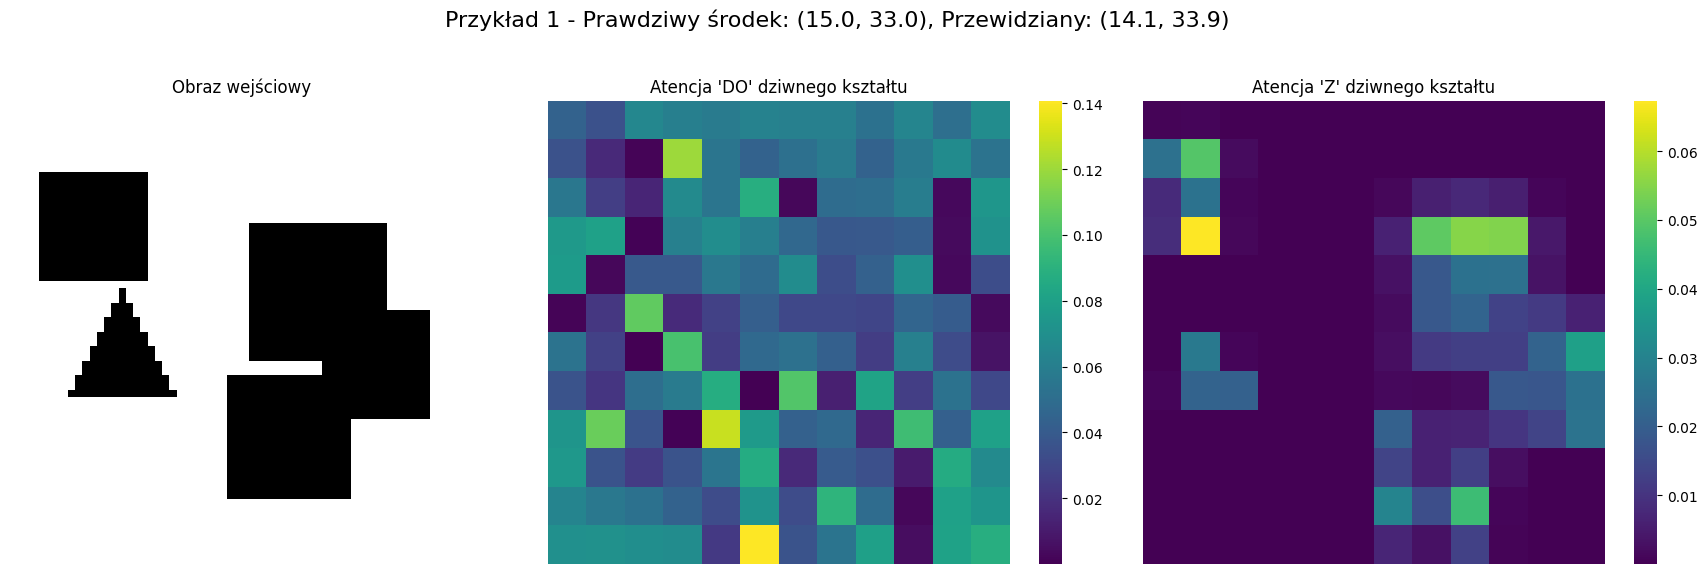

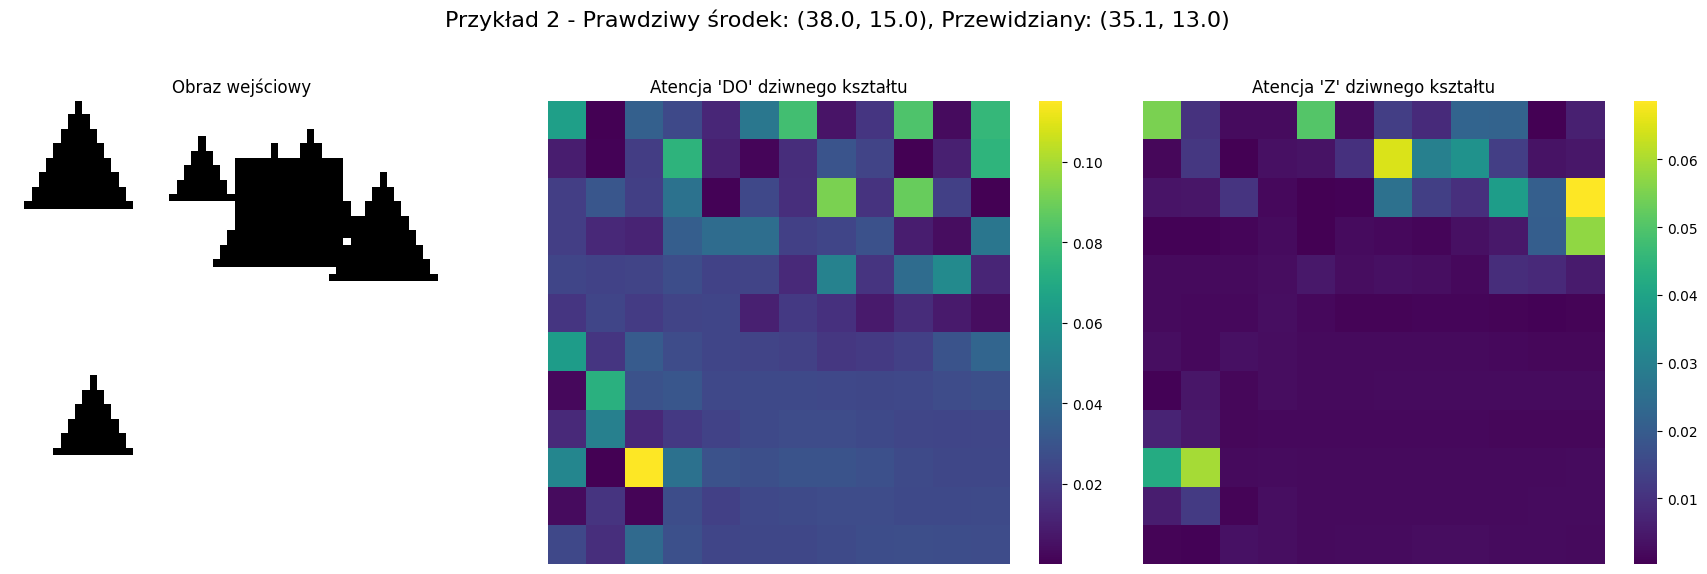

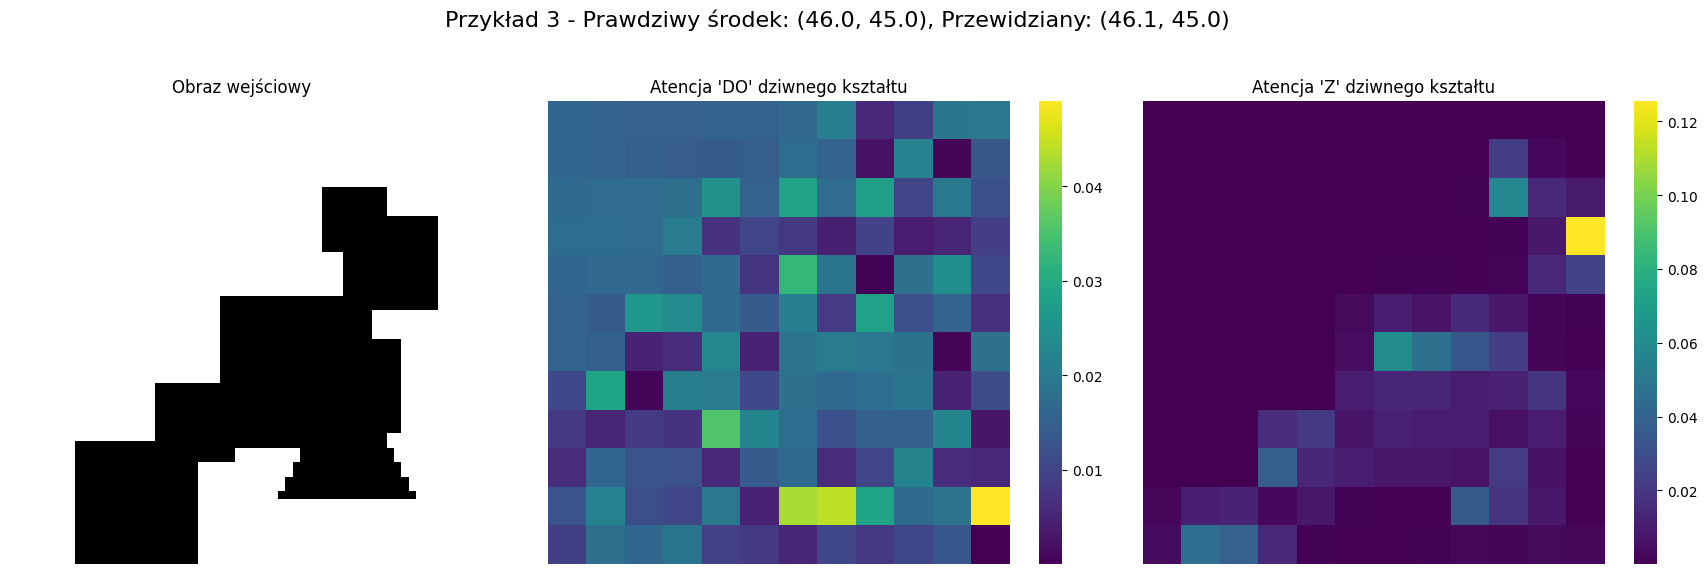

In [97]:
def visualize_attention(model, num_examples=3):
    dataset = OddXYDataset(num_samples=num_examples)
    loader = DataLoader(dataset, batch_size=1)
    model.eval()
    with torch.no_grad():
        for i, (image, label) in enumerate(loader):
            image_np = image.squeeze().cpu().numpy()
            cx_true, cy_true = label.squeeze().cpu().numpy()
            image_dev = image.to(device)
            pred_xy = model(image_dev)
            attention_matrix = model.attention.attention_weights.squeeze(0).cpu().numpy()
            stride, kernel_size = 4, 20
            col_idx, row_idx = int(round((cx_true - kernel_size/2)/stride)), int(round((cy_true - kernel_size/2)/stride))
            true_patch_idx = row_idx * model.grid_size + col_idx
            attention_to_odd = attention_matrix[:, true_patch_idx].reshape(model.grid_size, model.grid_size)
            attention_from_odd = attention_matrix[true_patch_idx, :].reshape(model.grid_size, model.grid_size)

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            fig.suptitle(f"Przykład {i+1} - Prawdziwy środek: ({cx_true:.1f}, {cy_true:.1f}), Przewidziany: ({pred_xy[0,0]:.1f}, {pred_xy[0,1]:.1f})", fontsize=16)
            axes[0].imshow(image_np, cmap='gray')
            axes[0].set_title("Obraz wejściowy")
            axes[0].axis('off')
            sns.heatmap(attention_to_odd, ax=axes[1], cmap='viridis', cbar=True)
            axes[1].set_title("Atencja 'DO' dziwnego kształtu")
            axes[1].set_xticks([]); axes[1].set_yticks([])
            sns.heatmap(attention_from_odd, ax=axes[2], cmap='viridis', cbar=True)
            axes[2].set_title("Atencja 'Z' dziwnego kształtu")
            axes[2].set_xticks([]); axes[2].set_yticks([])
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

visualize_attention(model)


Aby zwizualizować atencję, podzieliłem obrazki na 2 części. Pierwsza część pokazuje wagi atencji, które "patrzą" na centrum dziwnego kształtu, a druga część pokazuje na które elementy patrzy atencja dziwnego kształtu.

Ciężko jednoznacznie stwierdzić czy atencja robi, to co byśmy chcieli, natomiast raczej nie.
Samo centrum dziwnego kształtu zdaje się faktycznie patrzeć na inne kształty, natomiast nie możemy powiedzieć, że inne kształty bardziej patrzą na ten dziwny kształt, niż na przykłąd puste przestrzenie. Obrazki po lewej stronie wydają się być bardziej losowe, niż możnaby przypuszczać.